**Chapter 17 – Autoencoders and GANs**

_This notebook contains the sample from https://github.com/ageron/handson-ml2/ , https://github.com/fchollet/deep-learning-with-python-notebooks_ and https://github.com/probml/pml-book/tree/main/pml1

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math604/blob/master/static_files/presentations/05_Representation_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math604/blob/master/static_files/presentations/05_Representation_learning.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

A couple utility functions to plot grayscale 28x28 image:

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    

# Visualize 2d manifold from  encodings using tSNE

from sklearn.manifold import TSNE
import matplotlib

def plot_embeddings_tsne(X_data, y_data, encodings):
  np.random.seed(42)
  tsne = TSNE()
  X_data_2D = tsne.fit_transform(encodings)
  X_data_2D = (X_data_2D - X_data_2D.min()) / (X_data_2D.max() - X_data_2D.min())

  # adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
  plt.figure(figsize=(10, 8))
  cmap = plt.cm.tab10
  plt.scatter(X_data_2D[:, 0], X_data_2D[:, 1], c=y_data, s=10, cmap=cmap)
  image_positions = np.array([[1., 1.]])
  for index, position in enumerate(X_data_2D):
      dist = np.sum((position - image_positions) ** 2, axis=1)
      if np.min(dist) > 0.02: # if far enough from other images
          image_positions = np.r_[image_positions, [position]]
          imagebox = matplotlib.offsetbox.AnnotationBbox(
              matplotlib.offsetbox.OffsetImage(X_data[index], cmap="binary"),
              position, bboxprops={"edgecolor": cmap(y_data[index]), "lw": 2})
          plt.gca().add_artist(imagebox)
  plt.axis("off") 

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")   

# PCA with a linear Autoencoder

If the autoencoder uses only linear activations and the cost function is the mean squared error (MSE), then it ends up performing Principal Component Analysis. The following code builds a simple linear autoencoder to perform PCA on a 3D dataset, projecting it to 2D

In [ ]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

Text(0.5, 0, '$x_3$')

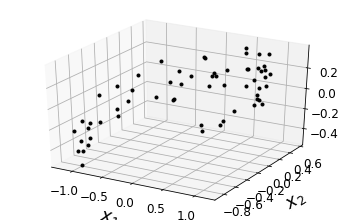

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(X_train[:, 0], X_train[:, 1], X_train[:, 2], "k.")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)

Now let's build the Autoencoder...

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

In [ ]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 0s 9ms/step - loss: 0.2547
Epoch 2/20
2/2 [==============================] - 0s 7ms/step - loss: 0.1032
Epoch 3/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0551
Epoch 4/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0503
Epoch 5/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0839
Epoch 6/20
2/2 [==============================] - 0s 7ms/step - loss: 0.2223
Epoch 7/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0913
Epoch 8/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0320
Epoch 9/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0242
Epoch 10/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0189
Epoch 11/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0142
Epoch 12/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0102
Epoch 13/20
2/2 [==============================] - 0s 7ms/step - loss: 0.

In [ ]:
codings = encoder.predict(X_train)

Saving figure linear_autoencoder_pca_plot


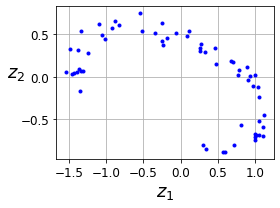

In [ ]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

As you can see, the autoencoder found the best 2D plane to project the data onto, preserving as much variance in the data as it could (just like PCA).

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
codings2 = pca.fit_transform(X_train)

In [ ]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings2[:,0], codings2[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

# Stacked Autoencoders

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

## MLP Layer

You can implement a stacked autoencoder very much like a regular deep MLP. The following code builds a stacked autoencoder for Fashion MNIST. we split the autoencoder model into two submodels: the encoder and the decoder.

* The encoder takes 28 × 28–pixel grayscale images, flattens them so that each image is represented as a vector of size 784, then processes these vectors through two Dense layers of diminishing sizes (100 units then 30 units), both using the SELU activation function. For each input image, the encoder outputs a vector of size 30.
* The decoder takes codings of size 30 (output by the encoder) and processes them through two Dense layers of increasing sizes (100 units then 784 units), and it reshapes the final vectors into 28 × 28 arrays so the decoder’s outputs have the same shape as the encoder’s inputs.
* When compiling the stacked autoencoder, we use the binary cross-entropy loss instead of the mean squared error. **We are treating the reconstruction task as a multilabel binary classification problem: each pixel intensity represents the probability that the pixel should be black**. Framing it this way (rather than
as a regression problem) tends to make the model converge faster
* We train the model using `X_train` as **both the inputs and the targets** (and similarly, we use `X_valid` as both the validation inputs and targets)


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=5,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 10s 5ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3170 - val_rounded_accuracy: 0.8996
Epoch 2/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9199
Epoch 3/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.2985 - val_rounded_accuracy: 0.9199
Epoch 4/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2938 - val_rounded_accuracy: 0.9285
Epoch 5/20
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2920 - val_rounded_accuracy: 0.9285
Epoch 6/20
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2914 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [===============

### Visualizing the Reconstructions

One way to ensure that an autoencoder is properly trained is to compare the inputs and the outputs: the differences should not be too significant. Let’s plot a few images from the validation set, as well as their reconstructions:

Saving figure reconstruction_plot


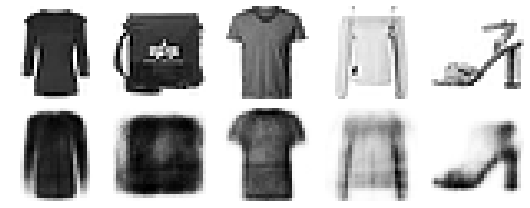

In [ ]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

### Visualizing Fashion MNIST

Now that we have trained a stacked autoencoder, we can use it to reduce the dataset’s dimensionality. For visualization, this does not give great results compared to other dimensionality reduction algorithms, but one big advantage of autoencoders is that they can handle large datasets, with many instances and many features. **So one strategy is to use an autoencoder to reduce the dimensionality down to a reasonable level, then use another dimensionality reduction algorithm for visualization**. Let’s use this strategy to visualize Fashion MNIST. First, we use the encoder from our stacked autoencoder to reduce the dimensionality down to 30, then we use Scikit-Learn’s implementation of the t-SNE algorithm to reduce the dimensionality down to 2 for visualization:

(5000, 30)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


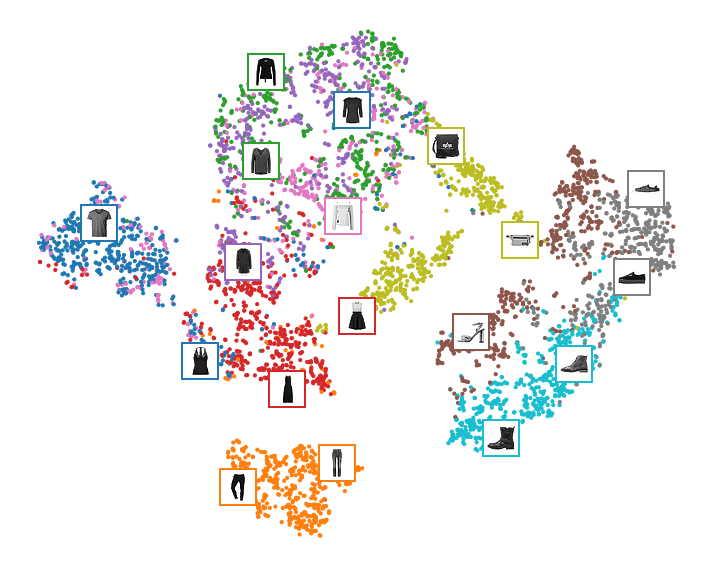

In [ ]:
Z = stacked_encoder.predict(X_valid)
print(Z.shape)
plot_embeddings_tsne(X_valid, y_valid, Z)
plt.tight_layout()
plt.savefig('ae-mlp-fashion-tsne.pdf')
plt.show()

The t-SNE algorithm identified several clusters which match the classes reasonably well (each class is represented with a different color).

## Using Convolutional Layers Instead of Dense Layers

If you are dealing with images, then the autoencoders we have seen so far will not work well (unless the images are very small): convolutional neural networks are far better suited than dense networks to work with images. So if you want to build an autoencoder for images, you will need to build a convolutional autoencoder. **The encoder is a regular CNN composed of convolutional layers and pooling layers.** It typically reduces the spatial dimensionality of the inputs (i.e., height and width) while increasing the depth (i.e., the number of feature maps). **The decoder must do the reverse (upscale the image and reduce its depth back to the original dimensions), and for this you can use transpose convolutional layers** (alternatively, you could combine upsampling layers with convolutional layers).

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/5
1719/1719 [==============================] - 23s 8ms/step - loss: 0.3018 - rounded_accuracy: 0.9187 - val_loss: 0.2851 - val_rounded_accuracy: 0.9282
Epoch 2/5
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2756 - rounded_accuracy: 0.9413 - val_loss: 0.2730 - val_rounded_accuracy: 0.9453
Epoch 3/5
1719/1719 [==============================] - 18s 10ms/step - loss: 0.2708 - rounded_accuracy: 0.9461 - val_loss: 0.2696 - val_rounded_accuracy: 0.9496
Epoch 4/5
1719/1719 [==============================] - 19s 11ms/step - loss: 0.2682 - rounded_accuracy: 0.9490 - val_loss: 0.2685 - val_rounded_accuracy: 0.9494
Epoch 5/5
1719/1719 [==============================] - 19s 11ms/step - loss: 0.2664 - rounded_accuracy: 0.9509 - val_loss: 0.2672 - val_rounded_accuracy: 0.9507


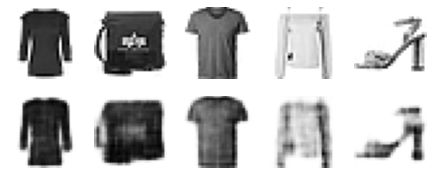

In [ ]:
show_reconstructions(conv_ae)

In [ ]:
Z = conv_encoder.predict(X_valid)
print(Z.shape)
N = Z.shape[0]
ZZ = np.reshape(Z, (N,-1))
print(ZZ.shape)


plot_embeddings_tsne(X_valid, y_valid, ZZ)
plt.tight_layout()
plt.savefig('ae-conv-fashion-tsne.pdf')
plt.show()

(5000, 3, 3, 64)
(5000, 576)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


## Recurrent Autoencoders

If you want to build an autoencoder for sequences, such as time series or text, then recurrent neural networks may be better suited than dense networks. Building a recurrent autoencoder is straightforward: **the encoder is typically a sequence-to-vector RNN** which compresses the input sequence down to a single vector. **The decoder is a vector-to-sequence RNN** that does the reverse:

In [ ]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

history = recurrent_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 63s 30ms/step - loss: 0.5192 - rounded_accuracy: 0.7492 - val_loss: 0.4581 - val_rounded_accuracy: 0.8081
Epoch 2/5
1719/1719 [==============================] - 52s 30ms/step - loss: 0.4051 - rounded_accuracy: 0.8432 - val_loss: 0.3743 - val_rounded_accuracy: 0.8678
Epoch 3/5
1719/1719 [==============================] - 50s 29ms/step - loss: 0.3653 - rounded_accuracy: 0.8711 - val_loss: 0.3603 - val_rounded_accuracy: 0.8767
Epoch 4/5
1719/1719 [==============================] - 49s 28ms/step - loss: 0.3508 - rounded_accuracy: 0.8809 - val_loss: 0.3524 - val_rounded_accuracy: 0.8772
Epoch 5/5
1719/1719 [==============================] - 49s 28ms/step - loss: 0.3406 - rounded_accuracy: 0.8875 - val_loss: 0.3362 - val_rounded_accuracy: 0.8919


This recurrent autoencoder can process sequences of any length, with 28 dimensions per time step. Conveniently, **this means it can process Fashion MNIST images by treating each image as a sequence of rows: at each time step, the RNN will process a single row of 28 pixels.** Note that we use a `RepeatVector` layer as the first layer of the decoder, to ensure that its input
vector gets fed to the decoder at each time step.

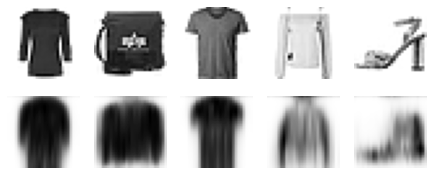

In [ ]:
show_reconstructions(recurrent_ae)

(5000, 30)
(5000, 30)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


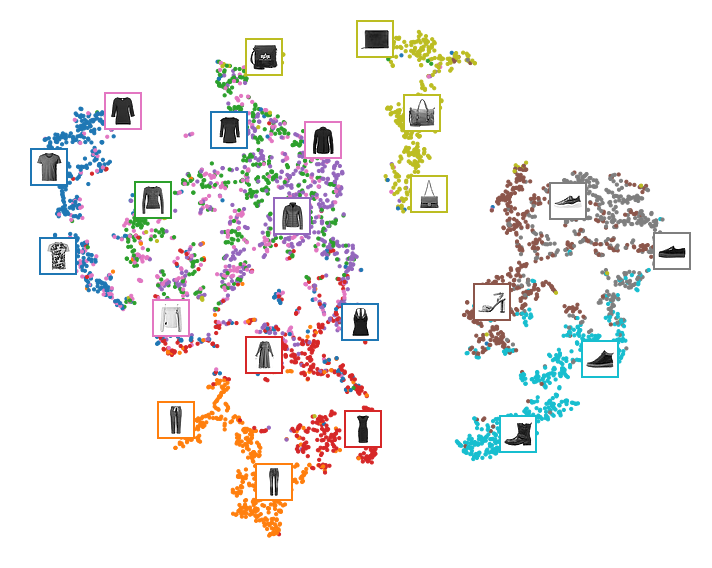

In [ ]:
Z = recurrent_encoder.predict(X_valid)
print(Z.shape)
N = Z.shape[0]
ZZ = np.reshape(Z, (N,-1))
print(ZZ.shape)


plot_embeddings_tsne(X_valid, y_valid, ZZ)
plt.tight_layout()
plt.show()

# Stacked denoising Autoencoder

Another way to force the autoencoder to learn useful features is to add noise to its inputs, training it to recover the original, noise-free inputs. The noise can be pure Gaussian noise added to the inputs, or it can be randomly switched-off inputs, just like in dropout (Bernoulli)

In [ ]:
# Add Gaussian noise

tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3500 - rounded_accuracy: 0.8773 - val_loss: 0.3166 - val_rounded_accuracy: 0.9078
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3120 - rounded_accuracy: 0.9097 - val_loss: 0.3089 - val_rounded_accuracy: 0.9153
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3060 - rounded_accuracy: 0.9148 - val_loss: 0.3033 - val_rounded_accuracy: 0.9179
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3025 - rounded_accuracy: 0.9179 - val_loss: 0.2999 - val_rounded_accuracy: 0.9218
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2996 - rounded_accuracy: 0.9205 - val_loss: 0.2973 - val_rounded_accuracy: 0.9238
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2974 - rounded_accuracy: 0.9223 - val_loss: 0.2959 - val_rounded_accuracy: 0.9267
Epoch 7/10
1719/1719 [==================

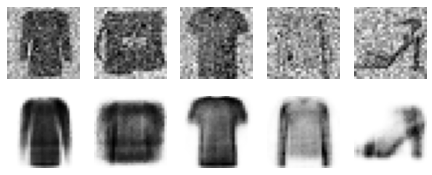

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

In [ ]:
# Add Bernoulli dropout noise

tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3568 - rounded_accuracy: 0.8710 - val_loss: 0.3200 - val_rounded_accuracy: 0.9041
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3182 - rounded_accuracy: 0.9032 - val_loss: 0.3125 - val_rounded_accuracy: 0.9110
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3128 - rounded_accuracy: 0.9075 - val_loss: 0.3075 - val_rounded_accuracy: 0.9153
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3092 - rounded_accuracy: 0.9102 - val_loss: 0.3041 - val_rounded_accuracy: 0.9178
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3067 - rounded_accuracy: 0.9123 - val_loss: 0.3015 - val_rounded_accuracy: 0.9193
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3048 - rounded_accuracy: 0.9139 - val_loss: 0.3014 - val_rounded_accuracy: 0.9173
Epoch 7/10
1719/1719 [==================

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)

Saving figure dropout_denoising_plot


# Sparse Autoencoder

Another kind of constraint that often leads to good feature extraction is sparsity: by adding an appropriate term to the cost function, the autoencoder is pushed to reduce the number of active neurons in the coding layer. For
example, it may be pushed to have on average only 5% significantly active neurons in the coding layer. This forces the autoencoder to represent each input as a combination of a small number of activations. As a result,
each neuron in the coding layer typically ends up representing a useful feature.

In [ ]:
# To visualize statistics of the hidden units adapted from https://github.com/probml/pml-book/tree/main/pml1/figure_notebooks

def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

def plot_activations_histogram2(encoder, height=1, n_bins=10, fname_base=""):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, ax1 = plt.subplots()
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    fname_act = '{}-act.pdf'.format(fname_base)
    #save_fig(fname_act)
    plt.show()
    
    fig, ax2 = plt.subplots()
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])
    fname_act = '{}-neurons.pdf'.format(fname_base)
    #save_fig(fname_act)
    plt.show()

def plot_activations_heatmap(encoder, N=100):
    X = encoder(X_valid).numpy()
    plt.figure(figsize=(10,5))
    plt.imshow(X[:N,:])
    plt.colorbar()

In [ ]:
# Simple AE with sigmoid activations on the bottleneck
    
tf.random.set_seed(42)
np.random.seed(42)

Nhidden = 300 
simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(Nhidden, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[Nhidden]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
1719/1719 [==============================] - 14s 7ms/step - loss: 0.3873 - rounded_accuracy: 0.8377 - val_loss: 0.3439 - val_rounded_accuracy: 0.8858
Epoch 2/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3260 - rounded_accuracy: 0.8988 - val_loss: 0.3210 - val_rounded_accuracy: 0.9051
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3152 - rounded_accuracy: 0.9075 - val_loss: 0.3139 - val_rounded_accuracy: 0.9094
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3096 - rounded_accuracy: 0.9122 - val_loss: 0.3091 - val_rounded_accuracy: 0.9142
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3055 - rounded_accuracy: 0.9156 - val_loss: 0.3054 - val_rounded_accuracy: 0.9171
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3023 - rounded_accuracy: 0.9183 - val_loss: 0.3028 - val_rounded_accuracy: 0.9192
Epoch 7/10
1719/1719 [===============

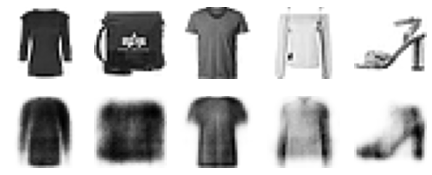

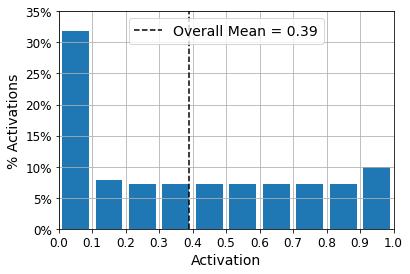

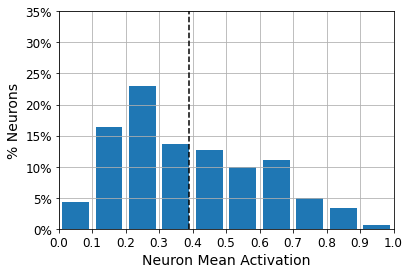

In [ ]:
show_reconstructions(simple_ae)
plot_activations_heatmap(simple_encoder)
plot_activations_histogram2(simple_encoder, height=0.35, fname_base="ae-sparse-noreg")
plt.show()

Three figures show neuron activity (in the bottleneck layer) for an autoencoder applied to Fashion MNIST. Heatmap of 300 neuron activations (columns) across 100 examples (rows). Histogram of activation levels derived from this heatmap. 
Histogram of the mean activation per neuron, averaged over all examples in the validation set. 

You can see that values close to 0 or 1 are more frequent overall, which is consistent with the saturating nature of the sigmoid function. Also, you can see that most neurons have a mean activation close to 0.5. Both histograms tell us that each neuron tends to either fire close to 0 or 1, with about 50% probability each. However, some neurons fire almost all the time (right side of the histogram).

A simple approach is to use the sigmoid activation function in the coding layer (to constrain the codings to values between 0 and 1), use a large coding layer (e.g., with 300 units), and add some ℓ regularization to the coding layer’s activations.

In [ ]:
# Add L1 regularizer

tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 14s 7ms/step - loss: 0.4310 - rounded_accuracy: 0.8129 - val_loss: 0.3808 - val_rounded_accuracy: 0.8555
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3690 - rounded_accuracy: 0.8689 - val_loss: 0.3638 - val_rounded_accuracy: 0.8741
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3545 - rounded_accuracy: 0.8799 - val_loss: 0.3502 - val_rounded_accuracy: 0.8857
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3437 - rounded_accuracy: 0.8876 - val_loss: 0.3418 - val_rounded_accuracy: 0.8898
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3372 - rounded_accuracy: 0.8920 - val_loss: 0.3368 - val_rounded_accuracy: 0.8949
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3320 - rounded_accuracy: 0.8968 - val_loss: 0.3316 - val_rounded_accuracy: 0.8992
Epoch 7/10
1719/1719 [================

The `ActivityRegularization` layer just returns its inputs, but as a side effect it adds a training loss equal to the sum of absolute values of its inputs (this layer only has an effect during training). layer. This penalty will encourage the neural network to produce codings close to 0, but since it
will also be penalized if it does not reconstruct the inputs correctly, it will have to output at least a few nonzero values. Using the ℓ norm rather than the ℓ norm will push the neural network to preserve the most important codings while eliminating the ones that are not needed for the input image (rather than just reducing all codings).

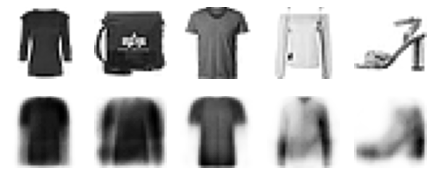

In [ ]:
show_reconstructions(sparse_l1_ae)
plot_activations_heatmap(sparse_l1_encoder)
plot_activations_histogram2(sparse_l1_encoder, fname_base="ae-sparse-L1reg")
#save_fig("ae-sparse-L1reg-heatmap.pdf")
plt.show()

Another approach, which often yields better results, is to measure the actual sparsity of the coding layer at each training iteration, and penalize the model when the measured sparsity differs from a target sparsity. We do so by
computing the average activation of each neuron in the coding layer, over the whole training batch. Once we have the mean activation per neuron, we want to penalize the neurons that are too active, or not active enough, by adding a sparsity loss to the cost function. 

Once we have computed the sparsity loss for each neuron in the coding layer, we sum up these losses and add the result to the cost function. In order to control the relative importance of the sparsity loss and the reconstruction
loss, we can multiply the sparsity loss by a sparsity weight hyperparameter. If this weight is too high, the model will stick closely to the target sparsity, but it may not reconstruct the inputs properly, making the model useless. Conversely, if it is too low, the model will mostly ignore the sparsity objective and will not learn any interesting features.

We now have all we need to implement a sparse autoencoder based on the KL divergence. First, let’s create a custom regularizer to apply KL divergence regularization:

In [ ]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 12s 6ms/step - loss: 0.4150 - rounded_accuracy: 0.8121 - val_loss: 0.3716 - val_rounded_accuracy: 0.8564
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3531 - rounded_accuracy: 0.8763 - val_loss: 0.3442 - val_rounded_accuracy: 0.8847
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3340 - rounded_accuracy: 0.8918 - val_loss: 0.3293 - val_rounded_accuracy: 0.8975
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3224 - rounded_accuracy: 0.9018 - val_loss: 0.3213 - val_rounded_accuracy: 0.9043
Epoch 5/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.3169 - rounded_accuracy: 0.9063 - val_loss: 0.3171 - val_rounded_accuracy: 0.9078
Epoch 6/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3135 - rounded_accuracy: 0.9093 - val_loss: 0.3140 - val_rounded_accuracy: 0.9105
Epoch 7/10
1719/1719 [===========

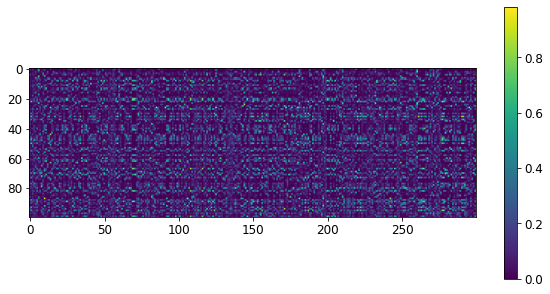

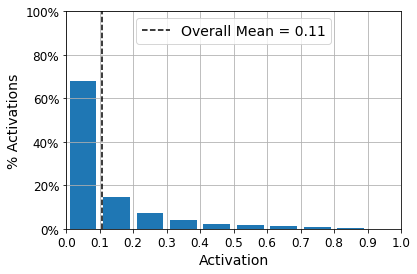

In [ ]:
show_reconstructions(sparse_kl_ae)
plot_activations_heatmap(sparse_kl_encoder)
plot_activations_histogram2(sparse_kl_encoder,  fname_base="ae-sparse-KLreg")
#save_fig("ae-sparse-KLreg-heatmap.pdf")
plt.show()

After training this sparse autoencoder on Fashion MNIST, the activations of the neurons in the coding layer are mostly close to 0 (about 70% of all activations are lower than 0.1), and all neurons have a mean activation around 0.1 (about 90% of all neurons have a mean activation between 0.1 and 0.2)

# Variational Autoencoder

We’re going to be implementing a VAE that can generate MNIST digits. It’s going to have three parts:

* An encoder network that turns a real image into a mean and a variance in the
latent space
* A sampling layer that takes such a mean and variance, and uses them to sample a random point from the latent space
* A decoder network that turns points from the latent space back into images

The following listing shows the encoder network we’ll use, mapping images to the
parameters of a probability distribution over the latent space. It’s a simple convnet that maps the input image x to two vectors, z_mean and z_log_var. One important detail is that we use strides for downsampling feature maps instead of max pooling. **Recall that, in general, strides are preferable to max pooling for any model that cares about information location**—that is to say, where stuff is in the image—and this one does, since it will have to produce an image encoding that can be used to reconstruct a valid image.

### VAE encoder

In [ ]:
from tensorflow.keras import layers

# Dimensionality of the latent space: a 2D plane
latent_dim = 2 

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
# The input image ends up being encoded into these two parameters.
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_3[0][0]']               
                                                                                                  
 flatten_6 (Flatten)            (None, 3136)         0           ['conv2d_4[0][0]']               
                                                                                            

### Latent-space-sampling layer

Next is the code for using `z_mean` and `z_log_var`, the parameters of the statistical distribution assumed to have produced input_img, to generate a latent space point z.

In [ ]:
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        # Draw a batch of random normal Apply the VAE vectors.
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        # Apply the VAE sampling formula
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### VAE decoder network, mapping latent space points to images

In [ ]:
# Input where we’ll feed z
latent_inputs = keras.Input(shape=(latent_dim,))
# Produce the same number of coefficients that we had at the level of the Flatten layer in the encoder.
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_30 (Dense)            (None, 3136)              9408      
                                                                 
 reshape_8 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 1)         289 

Now let’s create the VAE model itself. Whenever you depart from classic supervised learning, it’s common to subclass the Model class and implement a custom `train_step()` to specify the new training logic

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        # We use these metrics to keep track of the loss averages over each epoch.
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    # We list the metrics in the metrics property to enable the model to reset
    # them after each epoch (or between multiple calls to fit()/evaluate()).
    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            # We sum the reconstruction loss over the spatial
            # dimensions (axes 1 and 2) and take its mean over the
            # batch dimension.
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # Add the regularization term
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Finally, we’re ready to instantiate and train the model on MNIST digits. Because the loss is taken care of in the custom layer, we don’t specify an external loss at compile time (`loss=None`), which in turn means we won’t pass target data during training

In [ ]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

# We train on all MNIST digits, so we concatenate the training and test samples.
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)

# Note that we don’t pass a loss argument in compile(), since the loss
# is already part of the train_step().
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)

# Note that we don’t pass targets in fit(), since train_step()
# doesn’t expect any.
vae.fit(mnist_digits, epochs=30, batch_size=128)

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/30
547/547 [==============================] - 30s 53ms/step - total_loss: 203.8510 - reconstruction_loss: 200.8366 - kl_loss: 3.0142
Epoch 2/30
547/547 [==============================] - 41s 75ms/step - total_loss: 167.9008 - reconstruction_loss: 164.0855 - kl_loss: 3.8153
Epoch 3/30
547/547 [==============================] - 50s 91ms/step - total_loss: 160.0578 - reconstruction_loss: 156.3512 - kl_loss: 3.7066
Epoch 4/30
547/547 [==============================] - 26s 47ms/step - total_loss: 156.6668 - reconstruction_loss: 152.9863 - kl_loss: 3.6805
Epoch 5/30
547/547 [==============================] - 25s 46ms/step - total_loss: 154.6757 - reconstruction_loss: 151.0203 - kl_loss: 3.6554
Epoch 6/30
547/547 [==============================] - 24s 44ms/step - total_loss: 153.3843 - reconstruction_loss: 149.7089 - kl_loss: 3.6754
Epoch 7/30
547/547 [==============================] - 24s 44ms/step - total_loss: 152.422

Once the model is trained, we can use the decoder network to turn arbitrary latent space vectors into images.

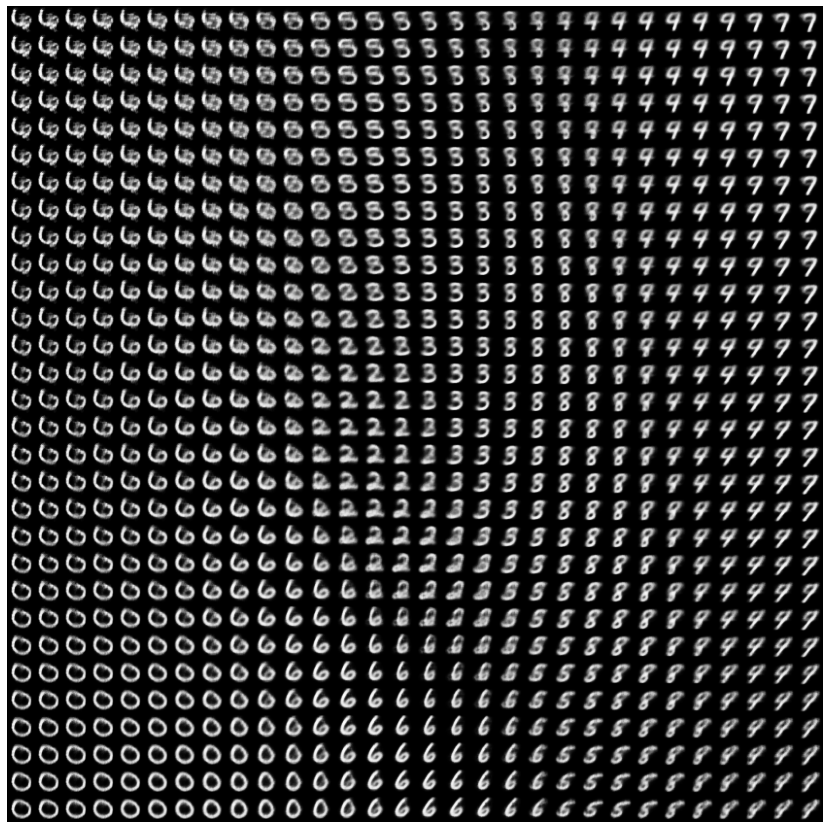

In [ ]:
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

The grid of sampled digits shows a completely continuous distribution of the different digit classes, with one digit morphing into another as you follow a
path through latent space. Specific directions in this space have a meaning: for example, there are directions for “five-ness,” “one-ness,” and so on.

# Generative Adversarial Networks

Let’s go ahead and build a simple GAN for Fashion MNIST. First, we need to build the generator and the discriminator. The generator is similar to an autoencoder’s decoder, and the discriminator is a regular binary classifier (it takes an image as input and ends with a Dense layer containing a single unit and using the sigmoid activation function). For the second phase of each training iteration, we also need the full GAN model containing the generator followed by the discriminator:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

Next, we need to compile these models. As the discriminator is a binary classifier, we can naturally use the binary cross-entropy loss. **The generator will only be trained through the gan model**, so we do not need to compile it at all. The gan model is also a binary classifier, so it can use the binary cross-entropy loss. Importantly, the discriminator should not be trained during the second phase, so we make it non-trainable before compiling the gan model:

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

Since the training loop is unusual, we cannot use the regular `fit()` method. Instead, we will write a custom training loop. For this, we first need to create a Dataset to iterate through the images:

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=20):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()      

As discussed earlier, you can see the two phases at each iteration:

* In phase one we feed Gaussian noise to the generator to produce fake images, and we complete this batch by concatenating an equal number of real images. The targets y1 are set to 0 for fake images and 1 for real images. Then we train the discriminator on this batch. Note that we set the discriminator’s
trainable attribute to True: this is only to get rid of a warning that Keras displays when it notices that trainable is now False but was True when the model was compiled (or vice versa).

* In phase two, we feed the GAN some Gaussian noise. Its generator will start by producing fake images, then the discriminator will try to guess whether these images are fake or real. We want the discriminator to believe that the fake images are real, so the targets y2 are set to 1. Note that we set the trainable attribute to False, once again to avoid a warning

Epoch 1/1


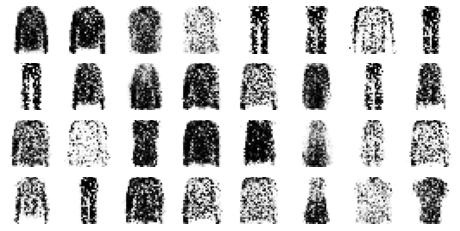

In [ ]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

Saving figure gan_generated_images_plot


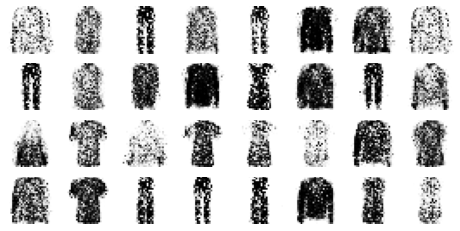

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)

Epoch 1/20


Epoch 2/20


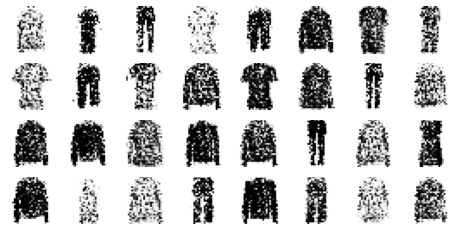

Epoch 3/20


Epoch 4/20


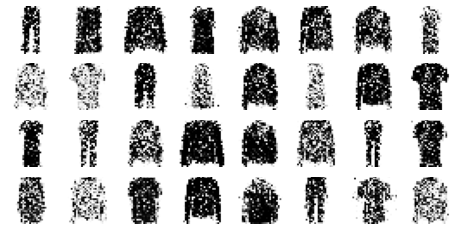

Epoch 5/20


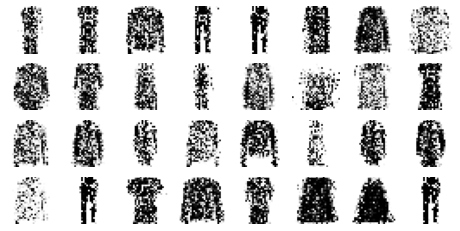

Epoch 6/20


Epoch 7/20


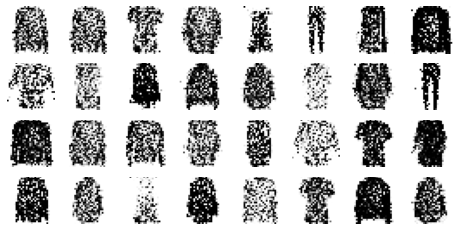

Epoch 8/20


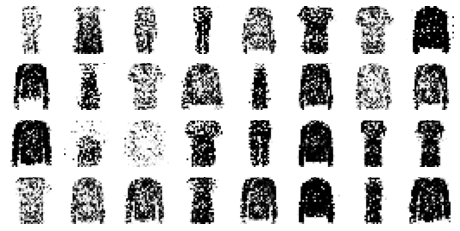

Epoch 9/20


Epoch 10/20


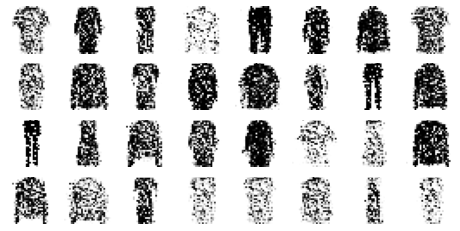

Epoch 11/20


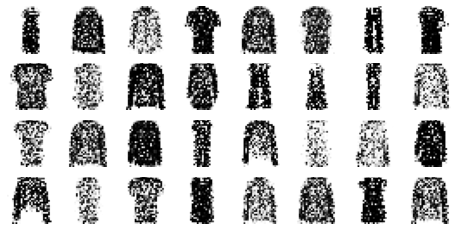

Epoch 12/20


Epoch 13/20


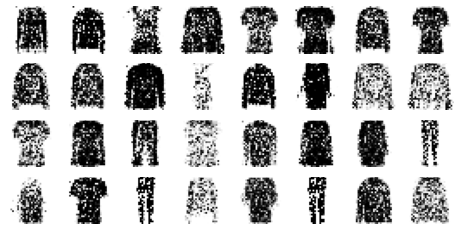

Epoch 14/20


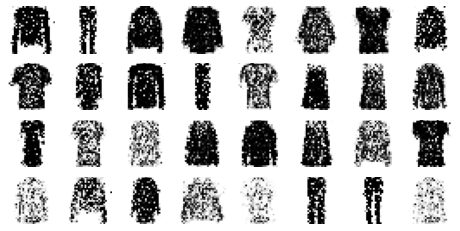

Epoch 15/20


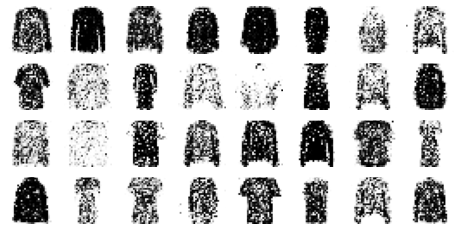

Epoch 16/20


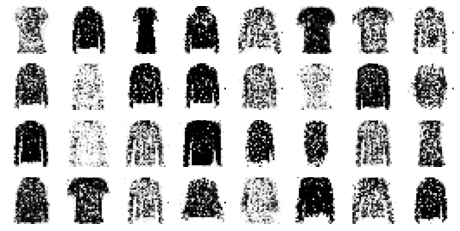

Epoch 17/20


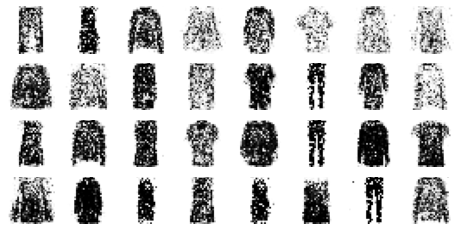

Epoch 18/20


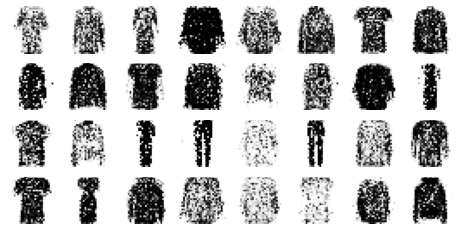

Epoch 19/20


Epoch 20/20


In [ ]:
train_gan(gan, dataset, batch_size, codings_size)

### Deep Convolutional GANs

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

The generator takes codings of size 100, and it projects them to 6272 dimensions (`7 * 7 * 128`), and reshapes the result to get a `7 × 7 × 128` tensor. This tensor is batch normalized and fed to a transposed convolutional layer with a stride of 2, which upsamples it from `7 × 7` to `14 × 14` and reduces its depth from 128 to 64. The result is batch normalized again and fed to another transposed convolutional layer with a stride of 2, which upsamples it
from `14 × 14` to `28 × 28` and reduces the depth from 64 to 1. This layer uses the tanh activation function, so the outputs will range from –1 to 1. For this reason, before training the GAN, we need to rescale the training set to
that same range. We also need to reshape it to add the channel dimension:

In [ ]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

The discriminator looks much like a regular CNN for binary classification, except instead of using max pooling layers to downsample the image, we use strided convolutions (strides=2). Also note that we use the leaky ReLU activation function.

Overall, we respected the DCGAN guidelines, except we replaced the BatchNormalization layers in the discriminator with Dropout layers (otherwise training was unstable in this case) and we replaced ReLU with SELU in the generator. Feel free to tweak this architecture: you will see how sensitive it is to the hyperparameters (especially the relative learning rates of the two networks).

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/20


Epoch 2/20


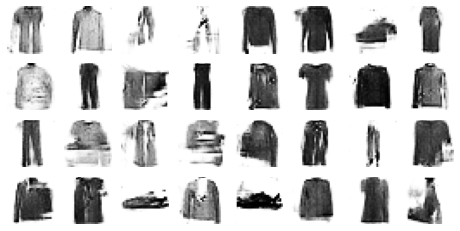

Epoch 3/20


Epoch 4/20


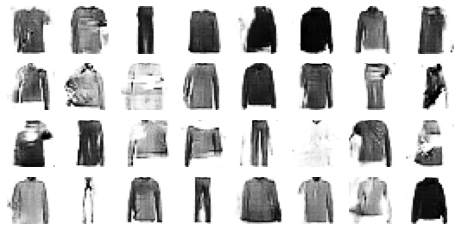

Epoch 5/20


Epoch 6/20


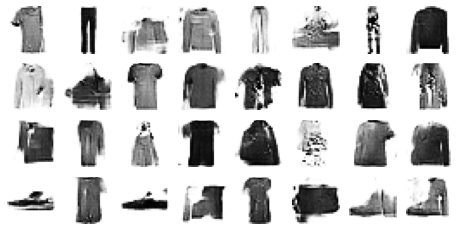

Epoch 7/20


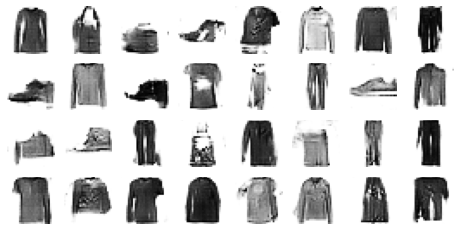

Epoch 8/20


Epoch 9/20


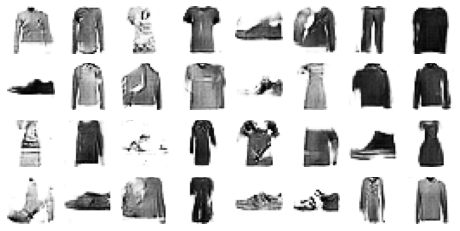

Epoch 10/20


Epoch 11/20


Epoch 12/20


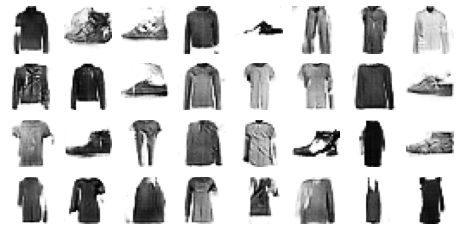

Epoch 13/20


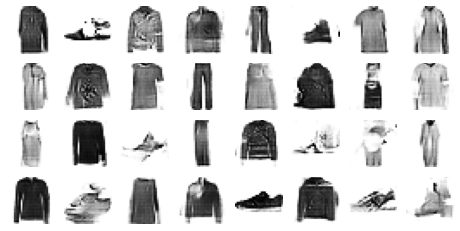

Epoch 14/20


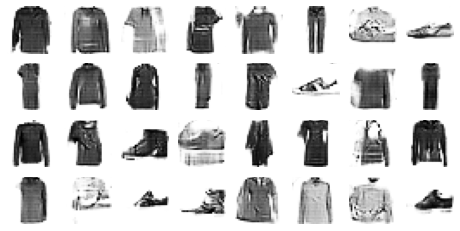

Epoch 15/20


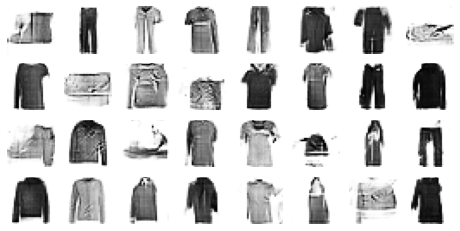

Epoch 16/20


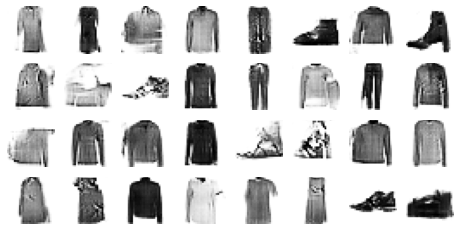

Epoch 17/20


Epoch 18/20


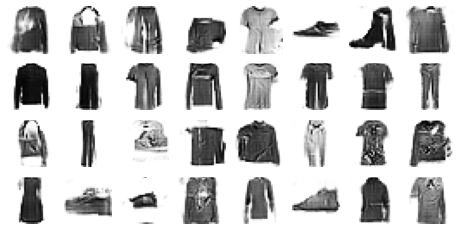

Epoch 19/20


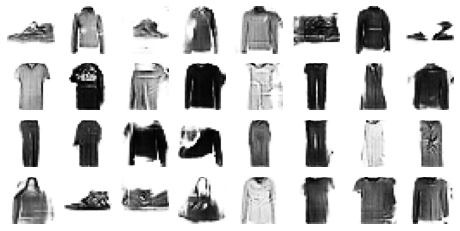

Epoch 20/20


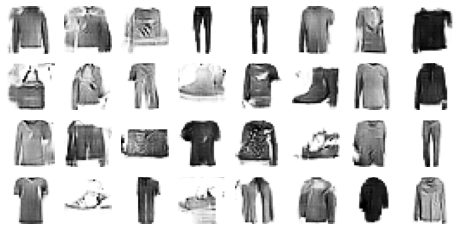

In [ ]:
train_gan(gan, dataset, batch_size, codings_size)

Saving figure dcgan_generated_images_plot


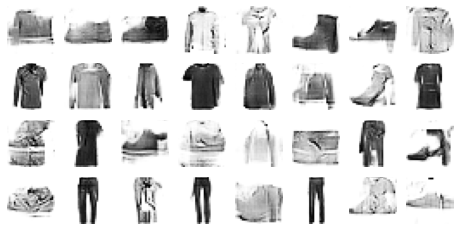

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)